In [62]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from numpy import pi
import math
from os import path

pd.options.mode.chained_assignment = None

# load laser tracker data
lt_all = pd.read_csv(path.expanduser("~/uwb_logs/laser_tracker/laser_tracker_data/cornaredo_from_xml.csv"))

# load uwb localization data from the 4 runs
u0 = pd.read_csv(path.expanduser("~/uwb_logs/laser_tracker/uwb_laser_tracker_bags/rosbag2_2024_07_26-12_14_22/position.csv"))
u1 = pd.read_csv(path.expanduser("~/uwb_logs/laser_tracker/uwb_laser_tracker_bags/rosbag2_2024_07_26-12_19_11/position.csv"))
u2 = pd.read_csv(path.expanduser("~/uwb_logs/laser_tracker/uwb_laser_tracker_bags/rosbag2_2024_07_26-12_21_45/position.csv"))
u3 = pd.read_csv(path.expanduser("~/uwb_logs/laser_tracker/uwb_laser_tracker_bags/rosbag2_2024_07_26-12_28_39/position.csv"))

# drop unnecessary index column
lt_all = lt_all.drop(columns=['Unnamed: 0'])

# correct time offset of laser tracker data wrt uwb localization data (uwb data is 1h70s late wrt laser tracker data)
lt_all.rename(columns={'x': 'n', 'y': 'e', 't': 't_orig'}, inplace=True)
lt_all['t'] = lt_all.t_orig + 60*60 + 70
lt_all['t_datetime'] = pd.to_datetime(lt_all.t_orig + 60*60 + 70, unit='s')

u0['t_datetime'] = pd.to_datetime(u0['t'], unit='s')   
u1['t_datetime'] = pd.to_datetime(u1['t'], unit='s')   
u2['t_datetime'] = pd.to_datetime(u2['t'], unit='s')
u3['t_datetime'] = pd.to_datetime(u3['t'], unit='s')

# uwb anchor coordinates
a1_u = pd.Series({'x': 0.0, 'y': 21.01})
a2_u = pd.Series({'x': 0.0, 'y': 0.0})
a3_u = pd.Series({'x': 9.68, 'y': 0.0})

# translate laser tracker data to match uwb origin coordinates
a2_lt = lt_all[(lt_all.name == 'TS0004') | (lt_all.name == 'TS0005') | (lt_all.name == 'TS0006')][['e', 'n']].mean()
print(f"offset: e={a2_lt.e}, n={a2_lt.n}")
lt_all.n = lt_all.n - a2_lt.n
lt_all.e = lt_all.e - a2_lt.e

# rotate laser tracker data to match uwb a3 coordinates (a3 is on the uwb reference frame x-axis)
a3_lt = lt_all[(lt_all.name == 'TS0007') | (lt_all.name == 'TS0008') | (lt_all.name == 'TS0009')][['e', 'n']].mean()
theta = -math.atan2(a3_lt.n, a3_lt.e)
print(f"offset: theta={theta}")
lt_all['x'] = lt_all.e * np.cos(theta) - lt_all.n * np.sin(theta)
lt_all['y'] = lt_all.e * np.sin(theta) + lt_all.n * np.cos(theta)

# recompute all laser tracker points and check alignment of third point
a1_lt = lt_all[(lt_all.name == 'TS0001') | (lt_all.name == 'TS0002') | (lt_all.name == 'TS0003')][['x', 'y']].mean()
a2_lt = lt_all[(lt_all.name == 'TS0004') | (lt_all.name == 'TS0005') | (lt_all.name == 'TS0006')][['x', 'y']].mean()
a3_lt = lt_all[(lt_all.name == 'TS0007') | (lt_all.name == 'TS0008') | (lt_all.name == 'TS0009')][['x', 'y']].mean()
print(f"a1_lt - a1_u: x={(a1_lt-a1_u).x:.4f}, y={(a1_lt-a1_u).y:.4f}")
print(f"a2_lt - a2_u: x={(a2_lt-a2_u).x:.4f}, y={(a2_lt-a2_u).y:.4f}")
print(f"a3_lt - a3_u: x={(a3_lt-a3_u).x:.4f}, y={(a3_lt-a3_u).y:.4f}")

# drop unnecessary rows (not recorded in uwb localization data)
lt = lt_all.iloc[10:]

# laser tracker timestamp of the start and end of each run
t_0 = lt[lt.name == "TS_Auto_0012"].iloc[0].t
t_1 = lt[lt.name == "TS_Auto_0656"].iloc[0].t
t_2 = lt[lt.name == "TS_Auto_1004"].iloc[0].t
t_3 = lt[lt.name == "TS_Auto_1554"].iloc[0].t
t_4 = lt[lt.name == "TS_Auto_2522"].iloc[0].t
print(f"t_0: {t_0}, t_1: {t_1}, t_2: {t_2}, t_3: {t_3}, t_4: {t_4}")
print(f"t_0: {pd.to_timedelta(t_0).total_seconds()}")

# laser tracker data each run
lt0 = lt[(t_0 < lt.t) & (lt.t <= t_1)]
lt1 = lt[(t_1 < lt.t) & (lt.t <= t_2)]
lt2 = lt[(t_2 < lt.t) & (lt.t <= t_3)]
lt3 = lt[(t_3 < lt.t) & (lt.t <= t_4)]


offset: e=3.301536, n=-2.7813326666666662
offset: theta=-2.5476708401666026
a1_lt - a1_u: x=-0.0290, y=-0.0464
a2_lt - a2_u: x=-0.0000, y=0.0000
a3_lt - a3_u: x=0.0359, y=0.0000
t_0: 1721988870.75, t_1: 1721988970.89, t_2: 1721989216.31, t_3: 1721989407.94, t_4: 1721989915.15
t_0: 1.721988


In [64]:
def interpolate_pose_2d_trajectories(trajectory_a_df, trajectory_b_df, trajectory_a_label='a', trajectory_b_label='b', average_rate=1.0, interpolation_tolerance=0.1, limit_trajectory_a_rate=False):
    a = trajectory_a_label
    b = trajectory_b_label

    trajectory_a_df['T'] = pd.to_datetime(trajectory_a_df.t, unit='s')
    trajectory_b_df['T'] = pd.to_datetime(trajectory_b_df.t, unit='s')

    tolerance = pd.Timedelta('{}s'.format(interpolation_tolerance))
    
    # interpolate trajectory_b around trajectory_a timestamps
    forward_matches = pd.merge_asof(
        left=trajectory_a_df[['T', 't', 'x', 'y']],
        right=trajectory_b_df[['T', 't', 'x', 'y']],
        on='T',
        direction='forward',
        tolerance=tolerance,
        suffixes=(f'_{a}', f'_{b}'))
    
    backward_matches = pd.merge_asof(
        left=trajectory_a_df[['T', 't', 'x', 'y']],
        right=trajectory_b_df[['T', 't', 'x', 'y']],
        on='T',
        direction='backward',
        tolerance=tolerance,
        suffixes=(f'_{a}', f'_{b}'))
    
    forward_backward_matches = pd.merge(
        left=backward_matches,
        right=forward_matches,
        on=f't_{a}')

    interpolated_trajectory_b_list = list()
    for index, row in forward_backward_matches.iterrows():
        t_b_1, t_b_2 = row[f't_{b}_x'], row[f't_{b}_y']
        t_int = row[f't_{a}']

        # if the trajectory_a time is too far from a trajectory_b time (before or after), do not use this trajectory_a data point
        if pd.isnull(t_b_1) or pd.isnull(t_b_2):
            continue

        x_a = row[f'x_{a}_x']
        x_b_1, x_b_2 = row[f'x_{b}_x'], row[f'x_{b}_y']
        x_int = np.interp(t_int, [t_b_1, t_b_2], [x_b_1, x_b_2])

        y_a = row[f'y_{a}_x']
        y_b_1, y_b_2 = row[f'y_{b}_x'], row[f'y_{b}_y']
        y_int = np.interp(t_int, [t_b_1, t_b_2], [y_b_1, y_b_2])

        interpolated_trajectory_b_list.append({
            't': t_int,
            f'x_{a}': x_a,
            f'y_{a}': y_a,
            f'x_{b}': x_int,
            f'y_{b}': y_int,
        })

    return pd.DataFrame(interpolated_trajectory_b_list)

ult0 = interpolate_pose_2d_trajectories(u0, lt0, 'u', 'lt', interpolation_tolerance=0.2)
ult1 = interpolate_pose_2d_trajectories(u1, lt1, 'u', 'lt', interpolation_tolerance=0.2)
ult2 = interpolate_pose_2d_trajectories(u2, lt2, 'u', 'lt', interpolation_tolerance=0.2)
ult3 = interpolate_pose_2d_trajectories(u3, lt3, 'u', 'lt', interpolation_tolerance=0.2)


forward_matches
                                 T           t_u   x_u    y_u          t_lt  \
0    2024-07-26 10:14:22.799788544  1.721989e+09  2.38  16.05           NaN   
1    2024-07-26 10:14:22.898763264  1.721989e+09  2.38  16.05           NaN   
2    2024-07-26 10:14:22.998548992  1.721989e+09  2.37  16.05           NaN   
3    2024-07-26 10:14:23.100652032  1.721989e+09  2.39  16.05           NaN   
4    2024-07-26 10:14:23.200000000  1.721989e+09  2.40  16.05           NaN   
...                            ...           ...   ...    ...           ...   
1036 2024-07-26 10:16:06.397836032  1.721989e+09  2.47   0.31  1.721989e+09   
1037 2024-07-26 10:16:06.492801536  1.721989e+09  2.48   0.28  1.721989e+09   
1038 2024-07-26 10:16:06.597913344  1.721989e+09  2.47   0.28  1.721989e+09   
1039 2024-07-26 10:16:06.697934848  1.721989e+09  2.46   0.28  1.721989e+09   
1040 2024-07-26 10:16:06.797973504  1.721989e+09  2.46   0.27  1.721989e+09   

          x_lt      y_lt  
0       

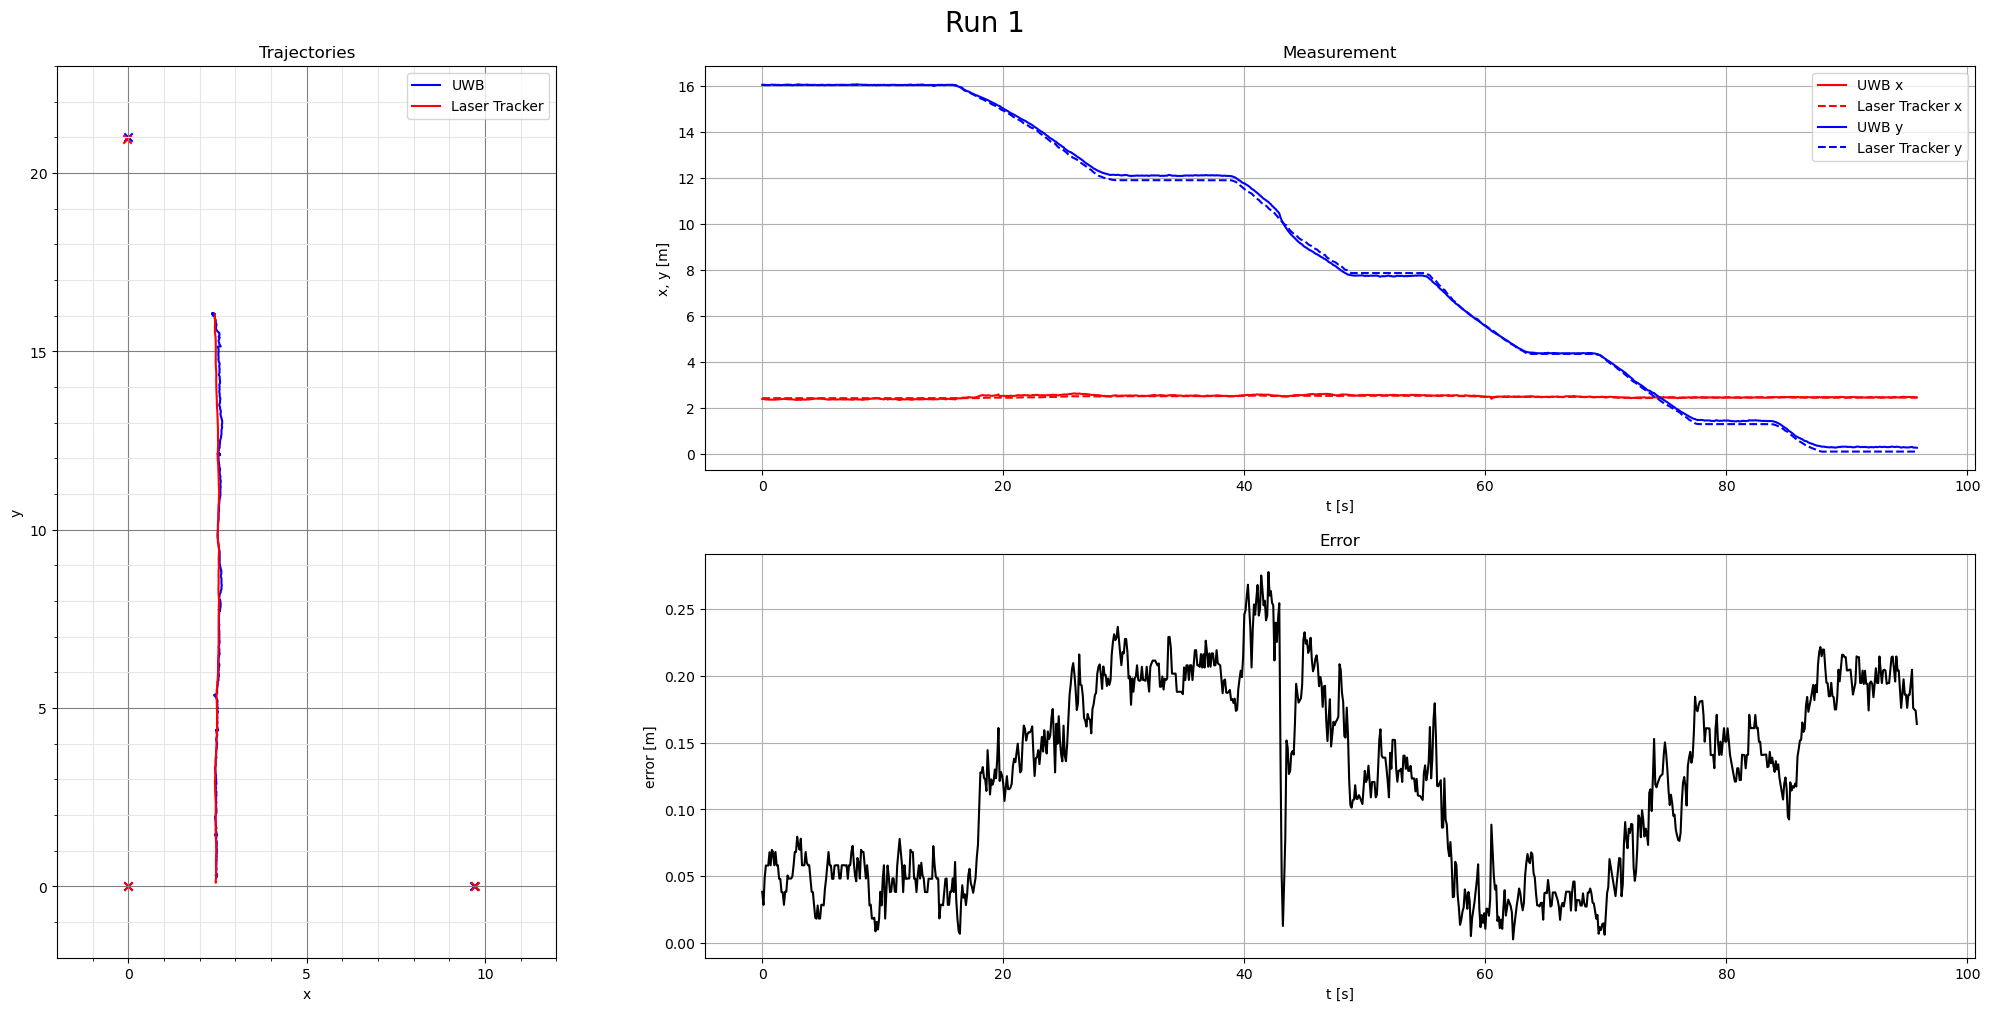

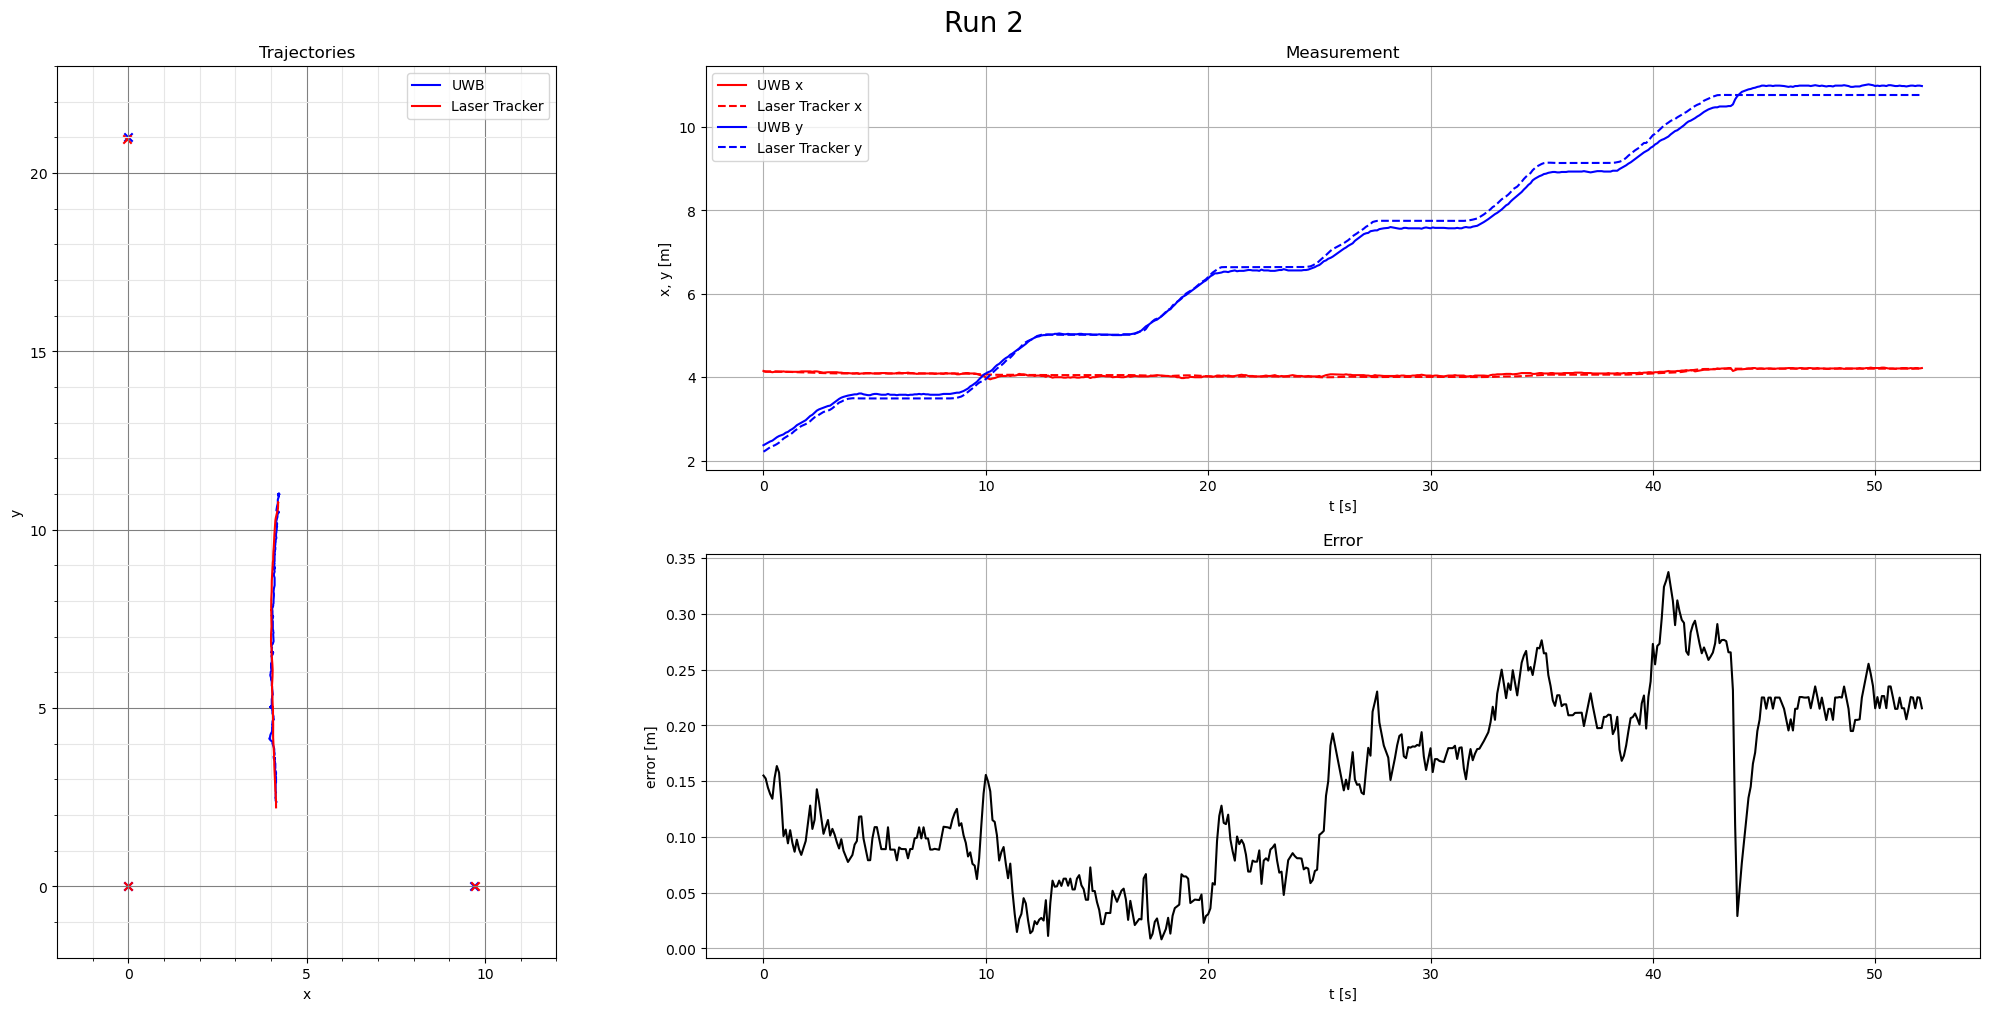

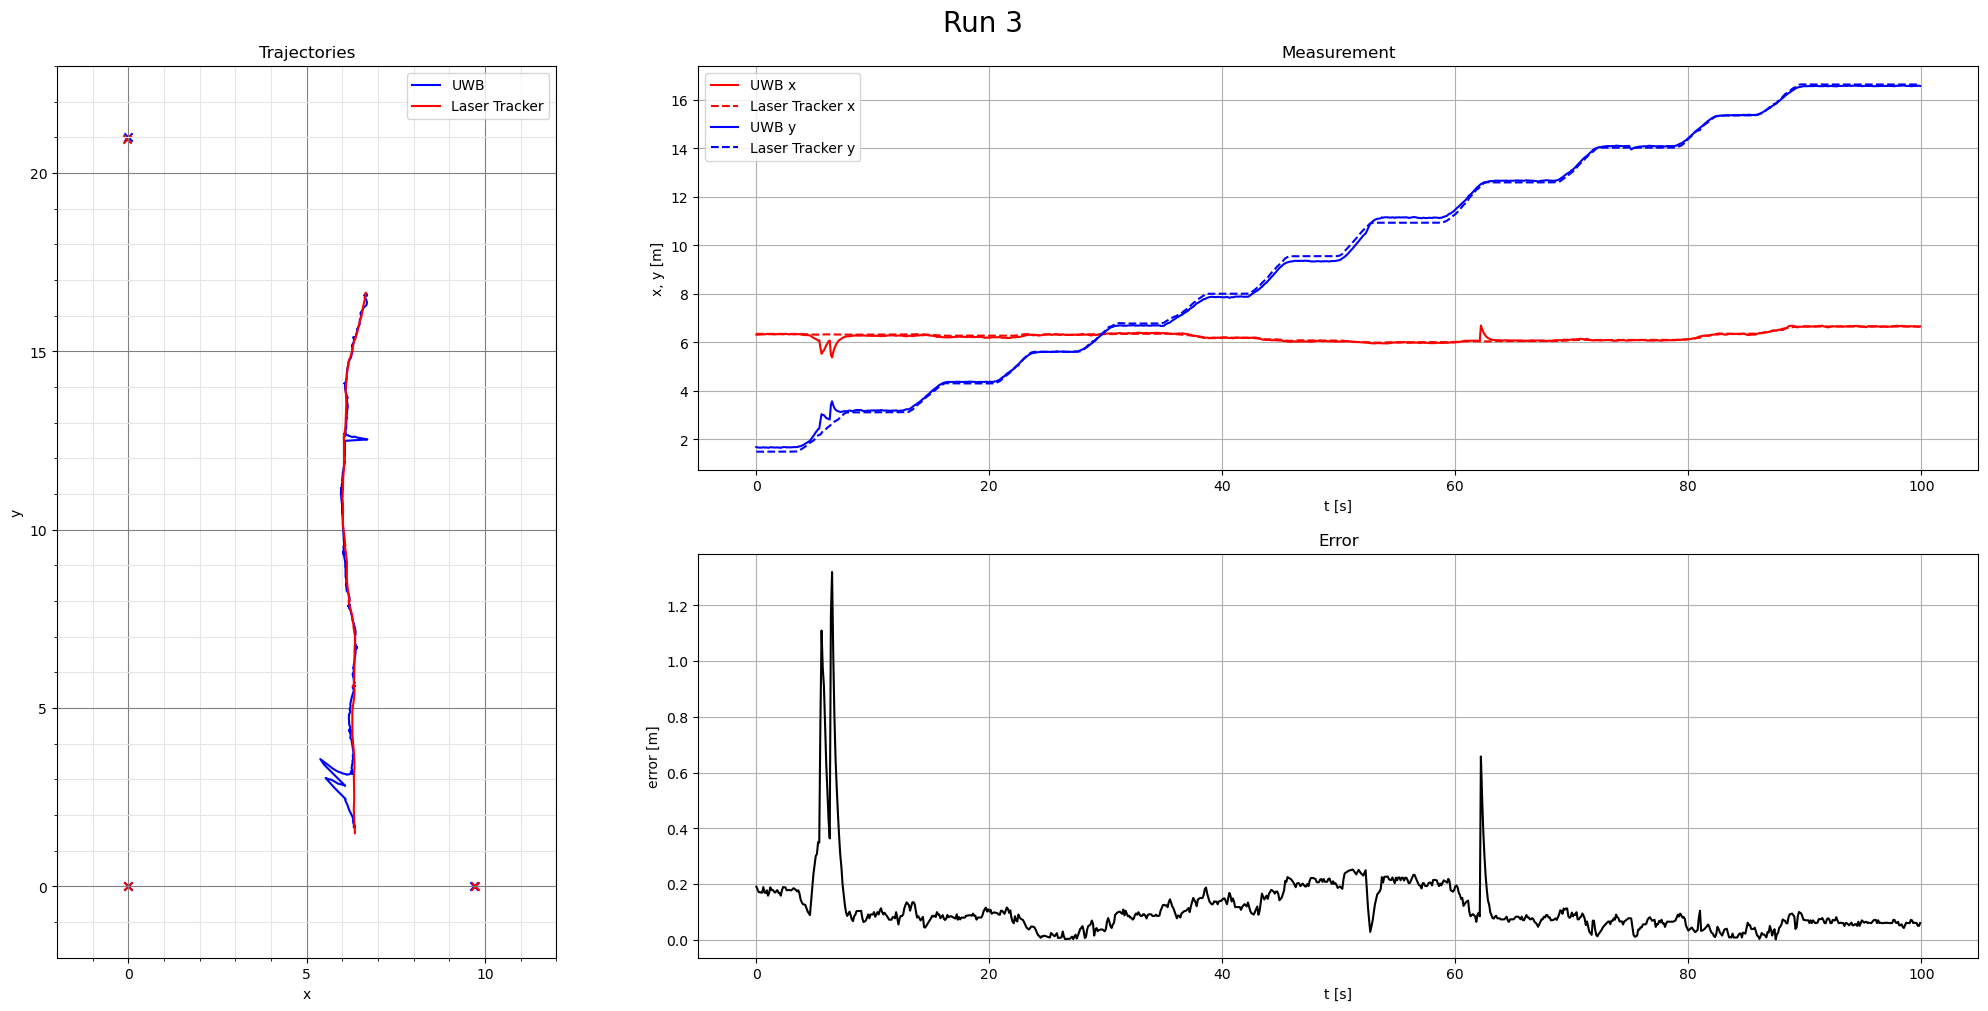

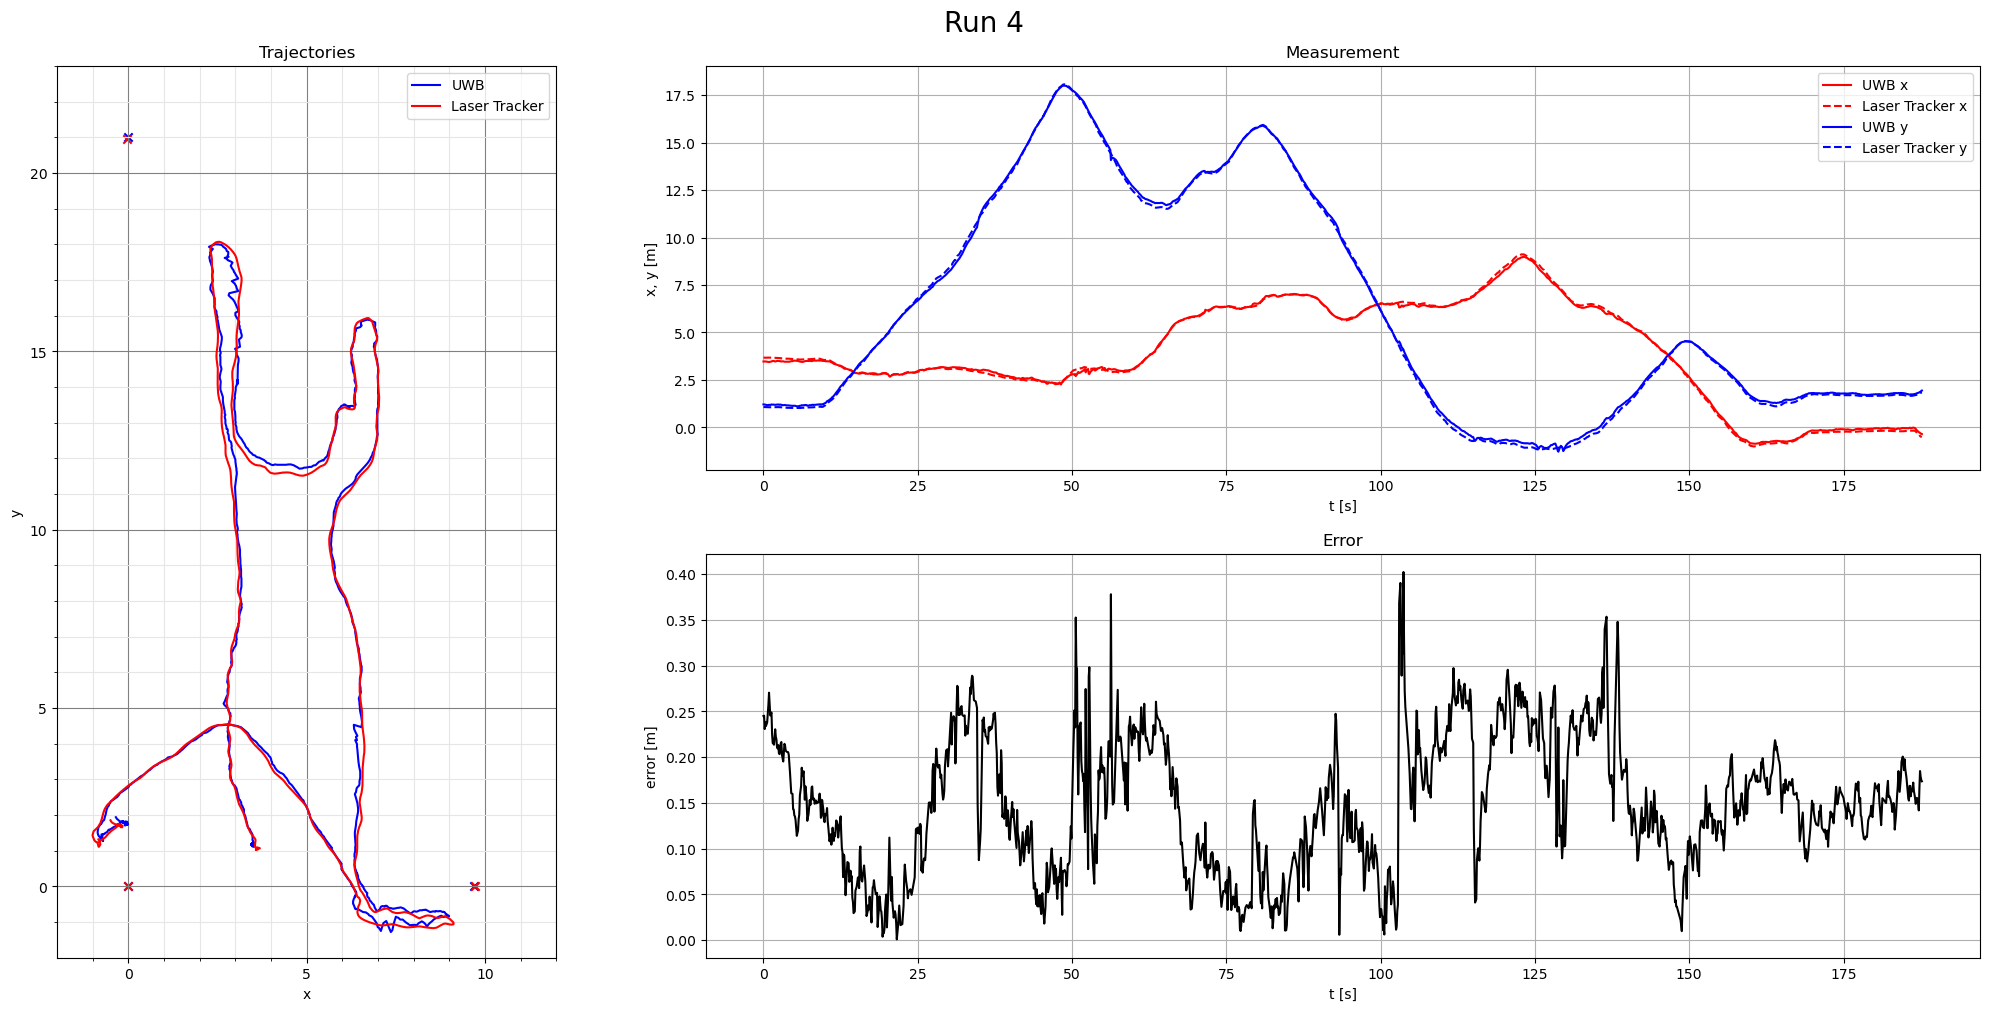

In [152]:
def all_plots(title, d):
    t0 = d.t.min()
    
    fig = plt.figure(constrained_layout=True, figsize=(20, 10), dpi=100)
    axs = fig.subplot_mosaic(
        [
            ['left', 'top_right'],
            ['left', 'bottom_right']
        ],
        gridspec_kw={'width_ratios':[1, 2]}
    )
    fig.suptitle(title, fontsize=20)
    
    axs['left'].set_title('Trajectories')
    axs['left'].set_xlim(-2, 12)
    axs['left'].set_ylim(-2, 23)
    axs['left'].set_aspect('equal')
    axs['left'].minorticks_on()
    axs['left'].grid(which='major', color=(0.5, 0.5, 0.5), linestyle='-')
    axs['left'].grid(which='minor', color=(0.9, 0.9, 0.9), linestyle='-')
    axs['left'].set_xlabel("x")
    axs['left'].set_ylabel("y")
    axs['left'].xaxis.set_major_locator(MaxNLocator(steps=[5]))
    axs['left'].yaxis.set_major_locator(MaxNLocator(steps=[5]))
    axs['left'].scatter(a1_u.x, a1_u.y, color='blue', marker='x')
    axs['left'].scatter(a2_u.x, a2_u.y, color='blue', marker='x')
    axs['left'].scatter(a3_u.x, a3_u.y, color='blue', marker='x')
    axs['left'].scatter(a1_lt.x, a1_lt.y, color='red', marker='x')
    axs['left'].scatter(a2_lt.x, a2_lt.y, color='red', marker='x')
    axs['left'].scatter(a3_lt.x, a3_lt.y, color='red', marker='x')
    axs['left'].plot(d.x_u, d.y_u, color='blue', label='UWB')
    axs['left'].plot(d.x_lt, d.y_lt, color='red', label='Laser Tracker')
    axs['left'].legend()
    
    axs['top_right'].set_title('Measurement')
    axs['top_right'].grid()
    axs['top_right'].set_xlabel("t [s]")
    axs['top_right'].set_ylabel("x, y [m]")
    axs['top_right'].plot(d.t-t0, d.x_u, color='red', label='UWB x')
    axs['top_right'].plot(d.t-t0, d.x_lt, '--', color='red', label='Laser Tracker x')
    axs['top_right'].plot(d.t-t0, d.y_u, color='blue', label='UWB y')
    axs['top_right'].plot(d.t-t0, d.y_lt, '--', color='blue', label='Laser Tracker y')
    axs['top_right'].legend()
    
    axs['bottom_right'].set_title('Error')
    axs['bottom_right'].grid()
    axs['bottom_right'].set_xlabel("t [s]")
    axs['bottom_right'].set_ylabel("error [m]")
    axs['bottom_right'].plot(d.t-t0, np.sqrt((d.x_u - d.x_lt)**2 + (d.y_u - d.y_lt)**2), color='black', label='error')
    
    plt.show()

all_plots("Run 1", ult0)
all_plots("Run 2", ult1)
all_plots("Run 3", ult2)
all_plots("Run 4", ult3)